# Explore `glacier_mass_change`

## Initialize Python environment

In [13]:
# Import standard libraries
import zipfile

# Import third party libraries
import cartopy.crs
import cdsapi
import IPython
import matplotlib.animation
import matplotlib.colors
import matplotlib.patches
import matplotlib.pyplot
import pandas
import xarray

# Ignore distracting warnings
import warnings
warnings.filterwarnings('ignore')

## Download data

We will use the [Climate Data Store (CDS) API](https://cds.climate.copernicus.eu/api-how-to) to download the [glacier mass change](https://cds.climate.copernicus.eu/cdsapp#!/dataset/derived-gridded-glacier-mass-change) dataset.

_NOTE: To use the CDS API, you first need to [register](https://cds.climate.copernicus.eu/user/register) (if not already), find your `UID` and `API key` on your [acount page](https://cds.climate.copernicus.eu/user), and fill them in below._

In [2]:
# Fill in your UID and API key (separated by a colon :)
KEY = 'UID:API Key'

c = cdsapi.Client(key=KEY)
c.retrieve(
    name='derived-gridded-glacier-mass-change',
    request={
        'variable': 'glacier_mass_change',
        'product_version': 'wgms_fog_2022_09',
        'format': 'zip',
        'hydrological_year': [
            '1975_76', '1976_77', '1977_78',
            '1978_79', '1979_80', '1980_81',
            '1981_82', '1982_83', '1983_84',
            '1984_85', '1985_86', '1986_87',
            '1987_88', '1988_89', '1989_90',
            '1990_91', '1991_92', '1992_93',
            '1993_94', '1994_95', '1995_96',
            '1996_97', '1997_98', '1998_99',
            '1999_20', '2000_01', '2001_02',
            '2002_03', '2003_04', '2004_05',
            '2005_06', '2006_07', '2007_08',
            '2008_09', '2009_10', '2010_11',
            '2011_12', '2012_13', '2013_14',
            '2014_15', '2015_16', '2016_17',
            '2017_18', '2018_19', '2019_20',
            '2020_21',
        ],
    },
    target='glacier_mass_change.zip'
)

2023-10-31 17:11:28,108 INFO Welcome to the CDS
2023-10-31 17:11:28,109 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/derived-gridded-glacier-mass-change
2023-10-31 17:11:28,507 INFO Request is completed
2023-10-31 17:11:28,509 INFO Downloading https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data8/dataset-derived-gridded-glacier-mass-change-bca4231f-7fa2-4103-8bda-0165b3bd4f2d.zip to glacier_mass_change.zip (4.2M)
2023-10-31 17:11:46,985 INFO Download rate 233.2K/s 


Result(content_length=4410916,content_type=application/zip,location=https://download-0012-clone.copernicus-climate.eu/cache-compute-0012/cache/data8/dataset-derived-gridded-glacier-mass-change-bca4231f-7fa2-4103-8bda-0165b3bd4f2d.zip)

Since the data is downloaded as a zip file, we have to first unzip it.

In [3]:
with zipfile.ZipFile('glacier_mass_change.zip', 'r') as file:
    file.extractall('glacier_mass_change')

## Read and inspect data

The data are formatted as multiple netCDF4 files, one for each year, but they can be read as a single dataset using [`xarray`](https://docs.xarray.dev).

In [53]:
ds = xarray.open_mfdataset('glacier_mass_change/*.nc4')
ds

<xarray.Dataset>
Dimensions:      (time: 46, lat: 360, lon: 720)
Coordinates:
  * time         (time) datetime64[ns] 1976-01-01 1977-01-01 ... 2021-01-01
  * lat          (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon          (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
Data variables:
    Glacier      (time, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    Uncertainty  (time, lat, lon) float64 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    title:         Global gridded annual glacier mass change product
    project:       Copernicus Climate Change Service (C3S) Essential Climate ...
    data_version:  version-wgms-fog-2022-09
    institution:   World Glacier Monitoring Service - Geography Department - ...
    created_by:    Dr. Ines Dussaillant   ines.dussaillant@geo.uzh.ch
    references:    Fluctuation of Glagiers (FoG) database version wgms-fog-20...
    citation:      
    Conventions:   CF Version CF-1.8
    comment:       Brief data description:Horizontal resolution:\t0.5° (latit...

Each `time` value contains a date, but represents a hydrological year. For example, `1976-01-01` represents the 1975–1976 hydrological year. To simplify what follows, we reduce each `time` to the end year of the hydrological year.

In [54]:
ds['time'] = [date.year for date in ds['time'].values.astype('datetime64[D]').tolist()]
ds['time']

<xarray.DataArray 'time' (time: 46)>
array([1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999,
       2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])
Coordinates:
  * time     (time) int64 1976 1977 1978 1979 1980 ... 2017 2018 2019 2020 2021

## Plot mass change on a map

### Static map for one year

We use [`matplotlib`](https://matplotlib.org/) and [`cartopy`](https://scitools.org.uk/cartopy/docs/latest) to make a map of glacier mass change for one year.

In [55]:
# Select year
YEAR = 2021

# Create a map with a plate carrée projection
figure = matplotlib.pyplot.figure(figsize=(12, 6))
axis = matplotlib.pyplot.axes(projection=cartopy.crs.PlateCarree())

# Add title
axis.set_title(f"Hydrological year {YEAR - 1}–{YEAR}")

# Add latitude, longitude gridlines
axis.gridlines(draw_labels=True, alpha=0.25, linestyle=':', color='white')

# Add white continents against a gray background
axis.set_facecolor('darkgray')
axis.add_feature(cartopy.feature.LAND, facecolor='lightgray')

# Define range and ticks of color scale
ticks = [-1, -0.1, -0.01, 0, 0.01, 0.1, 1]

# Plot mass loss in red and gain in blue
# A log scale is used for colors to highlight differences between regions
im = matplotlib.pyplot.pcolormesh(
    ds['lon'],
    ds['lat'],
    ds['Glacier'].loc[YEAR],
    cmap='RdBu',
    norm=matplotlib.colors.SymLogNorm(
        vmin=ticks[0], vmax=ticks[-1], linthresh=0.01
    )
)

# Add a colorbar with custom ticks
cbar = matplotlib.pyplot.colorbar(
    im,
    fraction=0.025,
    pad=0.05,
    label='Glacier mass change (Gt)',
    ticks=ticks
)
cbar.ax.set_yticklabels([f'< {ticks[0]}', *ticks[1:-1], f'> {ticks[-1]}'])

# Show plot
figure.tight_layout(pad=0)
matplotlib.pyplot.show()

### Animation for all years

Using the map above as a template, we create a map for each year and display them in an animation. Make sure to run this cell immediately after the cell above.

In [56]:
def animate(time_index: int) -> None:
    im.set_array(ds['Glacier'][time_index].values.ravel())
    year = ds['time'].values[time_index]
    axis.set_title(f"Hydrological year {year - 1}–{year}")

animation = matplotlib.animation.FuncAnimation(
    figure,
    func=animate,
    frames=ds['time'].size,
    interval=500  # ms
)

IPython.display.HTML(animation.to_jshtml())

## Plot timeseries of global mass change

### Compute mean of global change

The global mass change is the sum of the mass changes reported for each spatial grid cell. We compute it by summing mass change across the latitude (`lat`) and longitude (`lon`) dimensions.

In [57]:
global_change_mean = ds.sum(dim=['lat', 'lon'])['Glacier']

### Compute standard deviation of global change

If we assume that the mass changes for which we computed the sum above are uncorrelated, the standard deviation of their sum is the square root of the sum of the squares of their standard deviatons:

$
f = \textstyle\sum_i m_i \\
\sigma_f = \sqrt {\textstyle\sum_i \sigma_i^2}
$

See [Wikipedia: Propagation of uncertainty](https://en.wikipedia.org/wiki/Propagation_of_uncertainty) for more information.

We divide the uncertainty by 1.96 below because the authors report that this value is 1.96 $\sigma$ (equivalent to a 95% confidence interval for a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution)).

In [58]:
global_change_std = ((ds['Uncertainty'] / 1.96) ** 2).sum(dim=['lat', 'lon']) ** 0.5

### View timeseries as a table

We use [`pandas`](https://pandas.pydata.org) to tabulate the mean and standard deviation computed above.

In [59]:
pandas.DataFrame({
    'year': ds['time'],
    'mean': global_change_mean,
    'std': global_change_std
})

year        mean        std
0   1976   90.711681  29.427761
1   1977   -9.916545  29.827922
2   1978   -7.919292  29.135105
3   1979  -20.050397  29.187522
4   1980   80.726975  29.364131
5   1981   86.211509  31.511226
6   1982  -26.793842  28.662013
7   1983  140.430476  28.653894
8   1984  -29.203053  28.564248
9   1985   32.698277  28.637171
10  1986   69.848798  27.594141
11  1987  134.985990  27.841201
12  1988   12.617256  27.050033
13  1989  -18.082409  26.847752
14  1990 -248.443006  27.656334
15  1991 -143.120973  26.829816
16  1992  133.672195  26.663257
17  1993  -87.847944  26.652052
18  1994  -89.210215  26.410071
19  1995 -200.446107  26.171569
20  1996  -83.870737  25.528025
21  1997 -327.845908  24.748657
22  1998 -158.643409  24.510523
23  1999 -229.454042  24.563616
24  2000 -144.428798  12.284889
25  2001 -162.298628  12.494367
26  2002 -160.765585   9.332476
27  2003 -190.294174  14.942672
28  2004 -379.090233  11.315378
29  2005 -403.113326  11.086587
30  2006 -285.326933  11.548195
31  2007 -340.458477  11.253159
32  2008 -174.674641  11.426205
33  2009 -257.799645   8.735710
34  2010 -297.322767  11.295674
35  2011 -390.143004   9.291715
36  2012 -231.262888   9.896819
37  2013 -254.336647  11.493179
38  2014 -165.881781   8.630415
39  2015 -219.722406   8.452308
40  2016 -378.749650   9.953543
41  2017 -273.700155   7.438282
42  2018 -217.651581  12.309113
43  2019 -500.817056   8.147666
44  2020 -398.682773   7.292266
45  2021 -336.283551   8.161970

### Plot timeseries

We use [`matplotlib`](https://matplotlib.org/) to plot the mean and uncertainty of the global mass change for each year.

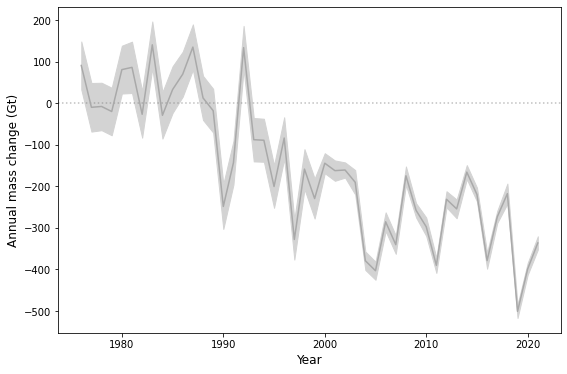

In [60]:
# Configure the figure
figure, axis = matplotlib.pyplot.subplots(1, 1, figsize=(9, 6))
axis.set_ylabel('Annual mass change (Gt)', fontsize=12)
axis.set_xlabel('Year', fontsize=12)

# Plot a horizontal line at 0 change
axis.axhline(y=0, alpha=0.5, linestyle=':', color='gray')

# Plot the uncertainty as 1.96 standard deviations below and above the mean
axis.fill_between(
    x=ds['time'],
    y1=global_change_mean - global_change_std * 1.96,
    y2=global_change_mean + global_change_std * 1.96,
    color='lightgray'
)

# Plot the mean as a line
axis.plot(
    ds['time'],
    global_change_mean,
    color='darkgray'
)

# Show figure
matplotlib.pyplot.show()

We can also plot this in the style of the popular climate [warming stripes](https://showyourstripes.info).

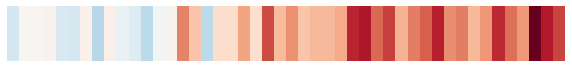

In [61]:
# Configure the figure
figure, axis = matplotlib.pyplot.subplots(1, 1, figsize=(10, 1))
axis.set_xlim(0, global_change_mean.size)
axis.set_axis_off()

# Define a red (negative) to blue (positive) colorscale
colormap = matplotlib.pyplot.get_cmap('RdBu')

# Saturate colors at -500 and +500 Gt
normalizer = matplotlib.colors.Normalize(vmin=-500, vmax=500)

# Create a colored rectangle for each year
for i, value in enumerate(global_change_mean):
    axis.add_patch(matplotlib.patches.Rectangle(
        xy=(i, 0), width=1, height=1, facecolor=colormap(normalizer(value))
    ))

# Show figure
matplotlib.pyplot.show()

## Plot total global mass change

Rather than plot the annual mass change, we would like to plot the total mass change accumulated from the beginning of the series to each subsequent year. To do so, we take the cumulative sum of the annual mass changes calculated above. To calculate the standard deviation of this total, we apply the same principle as before.

In [62]:
global_change_total = global_change_mean.cumsum()
global_change_total_std = (global_change_std ** 2).cumsum() ** 0.5

Again, we can use [`pandas`](https://pandas.pydata.org) to tabulate the total and its standard deviation.

In [63]:
pandas.DataFrame({
    'year': ds['time'],
    'total': global_change_total,
    'total_std': global_change_total_std
})

year        total   total_std
0   1976    90.711681   29.427761
1   1977    80.795136   41.901051
2   1978    72.875844   51.034816
3   1979    52.825448   58.791699
4   1980   133.552423   65.716939
5   1981   219.763931   72.881228
6   1982   192.970089   78.314650
7   1983   333.400565   83.392026
8   1984   304.197512   88.148433
9   1985   336.895789   92.683514
10  1986   406.744587   96.704035
11  1987   541.730577  100.632017
12  1988   554.347833  104.204161
13  1989   536.265424  107.607198
14  1990   287.822419  111.104373
15  1991   144.701446  114.297947
16  1992   278.373640  117.366733
17  1993   190.525696  120.354817
18  1994   101.315481  123.218399
19  1995   -99.130625  125.967158
20  1996  -183.001362  128.527837
21  1997  -510.847270  130.888888
22  1998  -669.490679  133.164059
23  1999  -898.944721  135.410627
24  2000 -1043.373519  135.966747
25  2001 -1205.672147  136.539612
26  2002 -1366.437732  136.858177
27  2003 -1556.731905  137.671508
28  2004 -1935.822139  138.135737
29  2005 -2338.935464  138.579920
30  2006 -2624.262397  139.060257
31  2007 -2964.720875  139.514833
32  2008 -3139.395516  139.981952
33  2009 -3397.195161  140.254267
34  2010 -3694.517928  140.708393
35  2011 -4084.660932  141.014849
36  2012 -4315.923820  141.361716
37  2013 -4570.260467  141.828164
38  2014 -4736.142249  142.090506
39  2015 -4955.864655  142.341679
40  2016 -5334.614305  142.689266
41  2017 -5608.314460  142.883010
42  2018 -5825.966041  143.412234
43  2019 -6326.783097  143.643494
44  2020 -6725.465870  143.828476
45  2021 -7061.749421  144.059877

Finally, we use [`matplotlib`](https://matplotlib.org/) to plot the total and its uncertainty.

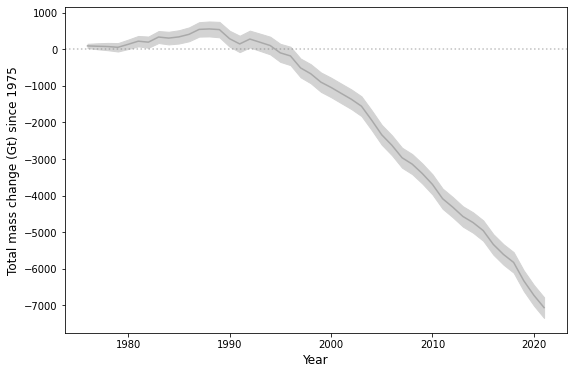

In [64]:
# Configure the figure
figure, axis = matplotlib.pyplot.subplots(1, 1, figsize=(9, 6))
start_year = ds['time'].values[0] - 1
axis.set_ylabel(f"Total mass change (Gt) since {start_year}", fontsize=12)
axis.set_xlabel('Year', fontsize=12)

# Plot a horizontal line at 0 change
axis.axhline(y=0, alpha=0.5, linestyle=':', color='gray')

# Plot the uncertainty as 1.96 standard deviations
axis.fill_between(
    x=ds['time'],
    y1=global_change_total - global_change_total_std * 1.96,
    y2=global_change_total + global_change_total_std * 1.96,
    color='lightgray'
)

# Plot the mean as a line
axis.plot(
    ds['time'],
    global_change_total,
    color='darkgray'
)

# Show figure
matplotlib.pyplot.show()